| PyTorch module      | What does it do?                                                                                       |
|---------------------|-------------------------------------------------------------------------------------------------------|
| torchvision        | Contains datasets, model architectures, and image transformations commonly used for computer vision problems. |
| torchvision.datasets | Provides access to many example computer vision datasets, such as image classification, object detection, and video classification. It also provides base classes for creating custom datasets. |
| torchvision.models  | Contains well-performing and commonly used computer vision model architectures implemented in PyTorch. You can use these models with your own problems. |
| torchvision.transforms | Contains common image transformations such as resizing, cropping, and flipping, which are often applied to images before being used with a model. |
| torch.utils.data.Dataset   | Base dataset class for PyTorch. It can be subclassed to create custom datasets. |
| torch.utils.data.DataLoader | Creates an iterable data loader for a dataset, which allows batch loading of the data and provides various data handling features like shuffling and parallel loading. |

# Convolution Neural Network (CNN)

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from helper_functions import set_seeds, plot_decision_boundary, accuracy_fn

## 1. Data Preparation

In [4]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_name = train_data.classes

Text(0.5, 1.0, 'Ankle boot')

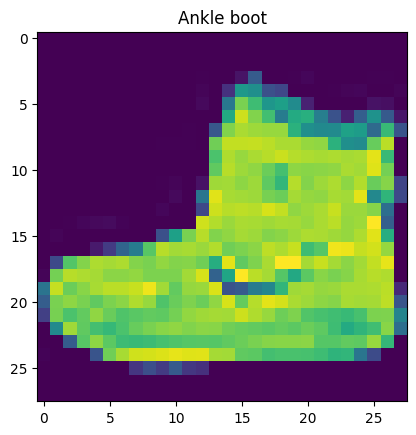

In [7]:
image, label = train_data[0]

image.shape
plt.imshow(image.squeeze())
plt.title(class_name[label])

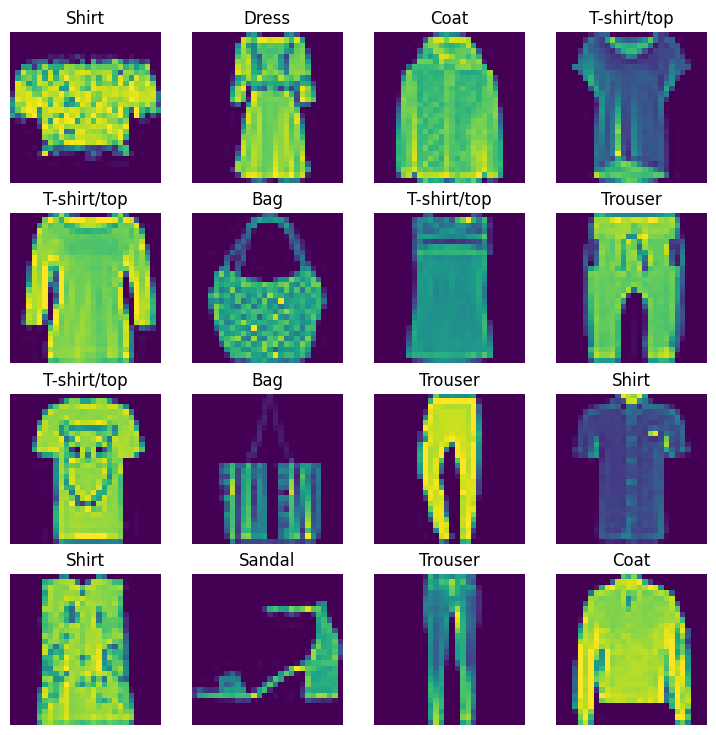

In [8]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.title(class_name[label])
    plt.axis(False)

## 2. DataLoader

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_data_loader.__len__(), test_data_loader.__len__()

(1875, 313)

In [10]:
# batch size of 32
60000/BATCH_SIZE, 10000/BATCH_SIZE

(1875.0, 312.5)

In [11]:
train_features_batch, train_labels_batch = next(iter(train_data_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 3. Build a baseline model

In [12]:
# turn Matrix into a single Vector Space
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before: {x.shape}")
print(f"Shape after: {output.shape}")

Shape before: torch.Size([1, 28, 28])
Shape after: torch.Size([1, 784])


In [13]:
class BaselineModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units):
        super(BaselineModel, self).__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_units),
            nn.Linear(hidden_units, output_dim),
        )

    def forward(self, x):
        return self.stack(x)

In [14]:
set_seeds()

baseline_model = BaselineModel(
    input_dim=784,
    hidden_units=10,
    output_dim=len(class_name)
    ).cuda()

In [15]:
dummy_x = torch.rand([1, 1, 28, 28], device='cuda')
baseline_model(dummy_x)

tensor([[-0.1246,  0.3679,  0.1569, -0.2142,  0.4448,  0.2504,  0.3336,  0.1542,
         -0.1502, -0.2144]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(baseline_model.parameters(), learning_rate)

In [17]:
from torchmetrics import Accuracy

# seed torch and cuda seed to 42
set_seeds()

# define
epochs = 3
train_size = len(train_data_loader)
test_size = len(test_data_loader)
acc = Accuracy('multiclass', num_classes=len(class_name))

# training loop
for epoch in range(epochs):
    # define train loss and accuracy
    train_loss = 0
    train_acc = 0

    # train mode
    baseline_model.train()
    for X_train, y_train in train_data_loader:
        # to cuda
        X_train, y_train = X_train.cuda(), y_train.cuda()

        # forward
        y_pred = baseline_model(X_train)
        loss = criterion(y_pred, y_train)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        train_loss += loss.item()
        train_acc += acc(y_pred.argmax(dim=1).cpu(), y_train.cpu())

    # update train loss and accuracy
    train_loss /= train_size
    train_acc /= train_size

    # define test loss and accuracy
    test_loss = 0
    test_acc = 0

    # test mode
    baseline_model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_data_loader:
            # to cuda
            X_test, y_test = X_test.cuda(), y_test.cuda()

            # forawrd
            test_pred = baseline_model(X_test)
            loss = criterion(test_pred, y_test)

            # calculate loss and accuracy
            test_loss += loss.item()
            test_acc += acc(test_pred.argmax(dim=1).cpu(), y_test.cpu())

        # update train loss and accuracy
        test_loss /= test_size
        test_acc /= test_size

    print(f"Epoch: {epoch+1}, Train loss: {loss:.5f}, Train acc: {train_acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

# clean gpu cache
torch.cuda.empty_cache()

Epoch: 1, Train loss: 0.30739, Train acc: 0.79%, Test loss: 0.50954, Test acc: 0.82%
Epoch: 2, Train loss: 0.27560, Train acc: 0.83%, Test loss: 0.47989, Test acc: 0.83%
Epoch: 3, Train loss: 0.32980, Train acc: 0.84%, Test loss: 0.47664, Test acc: 0.83%


## 4. Build a non-linear model

In [18]:
class NonLinearModel(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super(NonLinearModel, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [19]:
set_seeds()

nonlinear_model = NonLinearModel(
    input_shape=28*28,
    hidden_units=100,
    output_shape=len(class_name))

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()

# learning rate and optimizer
learning_rate = 0.1
optimizer = optim.SGD(nonlinear_model.parameters(), learning_rate)

In [21]:
def train_step(model: nn.Module, dataset: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device = 'cpu'):
    # define train loss and accuracy
    train_loss, train_acc = 0, 0
    train_size = len(dataset)
    
    # model device
    model.to(device)

    # train mode
    model.train()

    # loop through the batches
    for X_train, y_train in dataset:
        # data device
        X_train, y_train = X_train.to(device), y_train.to(device)

        # forward
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        train_loss += loss.item()
        train_acc += acc(outputs.argmax(dim=1).cpu(), y_train.cpu())

    # update train loss and accuracy
    train_loss /= train_size
    train_acc /= train_size

    return train_loss, train_acc

In [22]:
def test_step(model: nn.Module, dataset: DataLoader, criterion: nn.Module, device: torch.device = 'cpu'):
    # define test loss and accuracy
    test_loss, test_acc = 0, 0
    test_size = len(dataset)

    # model device
    model.to(device)

    # test mode
    model.eval()
    with torch.inference_mode():
        # loop through the batches
        for X_test, y_test in dataset:
            # data device
            X_test, y_test = X_test.to(device), y_test.to(device)

            # forawrd
            outputs = model(X_test)
            loss = criterion(outputs, y_test)

            # calculate loss and accuracy
            test_loss += loss.item()
            test_acc += acc(outputs.argmax(dim=1).cpu(), y_test.cpu())

        # update train loss and accuracy
        test_loss /= test_size
        test_acc /= test_size

    return test_loss, test_acc

In [23]:
from torchmetrics import Accuracy

# seed torch and cuda seed to 42
set_seeds()

# define
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
acc = Accuracy(task='multiclass', num_classes=len(class_name))

# training loop
for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}\n----------")

    train_loss, train_acc = train_step(model=nonlinear_model,
               dataset=train_data_loader,
               criterion=criterion,
               optimizer=optimizer,
               device=device)
    
    test_loss, test_acc = test_step(model=nonlinear_model,
              dataset=test_data_loader,
              criterion=criterion,
              device=device)
    
    print(f"Train loss: {train_loss:.5f}, Train accuracy: {train_acc:.2f} | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}")
    
torch.cuda.empty_cache()


Epoch: 1
----------
Train loss: 1.13322, Train accuracy: 0.60 | Test loss: 0.47879, Test accuracy: 0.83

Epoch: 2
----------
Train loss: 0.42286, Train accuracy: 0.85 | Test loss: 0.42741, Test accuracy: 0.85

Epoch: 3
----------
Train loss: 0.37781, Train accuracy: 0.86 | Test loss: 0.39651, Test accuracy: 0.86


## 5. Build a Convolution Neural Network (CNN)

In [24]:
class VGG16(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super(VGG16, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        out = self.classifier(x)
        return out

In [25]:
set_seeds()

cnn_model = VGG16(input_shape=1,
                  output_shape=len(class_name),
                  hidden_units=10)

In [26]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(cnn_model.parameters(), learning_rate)

In [27]:
# seed torch and cuda seed to 42
set_seeds()

# define
epochs = 3

# training loop
for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}\n----------")

    train_loss, train_acc = train_step(model=cnn_model,
               dataset=train_data_loader,
               criterion=criterion,
               optimizer=optimizer,
               device=device)
    
    test_loss, test_acc = test_step(model=cnn_model,
              dataset=test_data_loader,
              criterion=criterion,
              device=device)
    
    print(f"Train loss: {train_loss:.5f}, accuracy: {train_acc:.2f} | Test loss: {test_loss:.5f}, accuracy: {test_acc:.2f}")

torch.cuda.empty_cache()


Epoch: 1
----------
Train loss: 0.59126, accuracy: 0.79 | Test loss: 0.39230, accuracy: 0.86

Epoch: 2
----------
Train loss: 0.36443, accuracy: 0.87 | Test loss: 0.35520, accuracy: 0.87

Epoch: 3
----------
Train loss: 0.32828, accuracy: 0.88 | Test loss: 0.32583, accuracy: 0.88


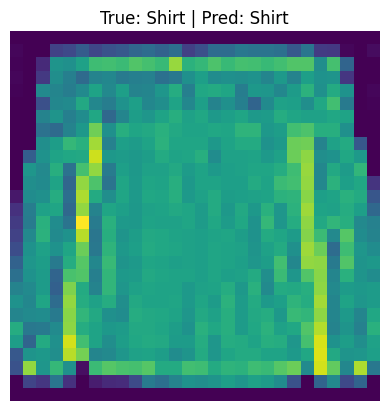

In [28]:
image, label = test_data[torch.randint(0, len(test_data), size=[1]).item()]

y_pred = cnn_model(image.cuda().unsqueeze(0)).argmax()

plt.title(f"True: {class_name[label]} | Pred: {class_name[y_pred.item()]}")
plt.axis(False)
plt.imshow(image.squeeze())

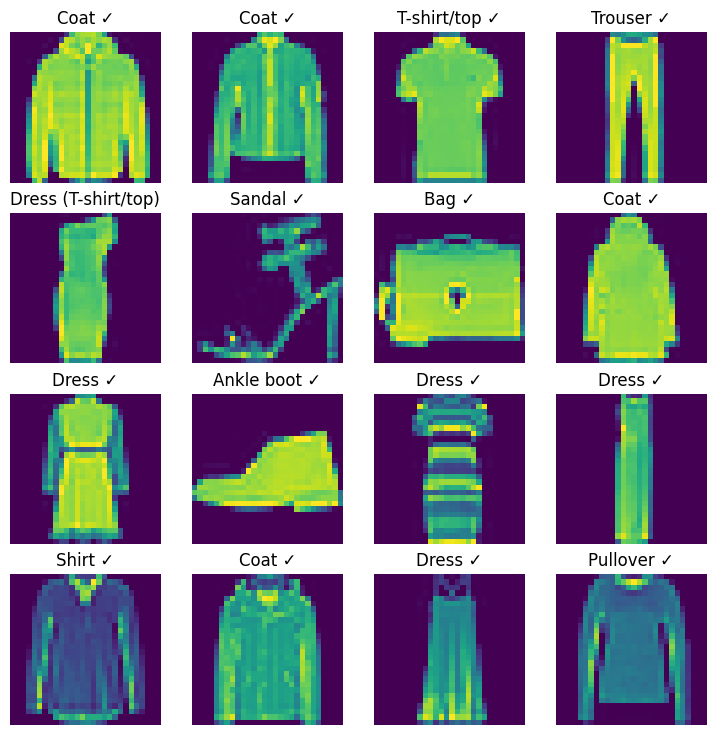

In [29]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

cnn_model.eval()
with torch.inference_mode():
    for i in range(1, rows*cols+1):
        random_idx = torch.randint(0, len(test_data), size=[1]).item()
        image, label = test_data[random_idx]
        y_pred = cnn_model(image.cuda().unsqueeze(0)).argmax()
        fig.add_subplot(rows, cols, i)
        plt.imshow(image.squeeze())
        plt.title(f"{class_name[y_pred.item()]} " + ("✓" if (y_pred.item() == label) else f"({class_name[label]})"))
        plt.axis(False)

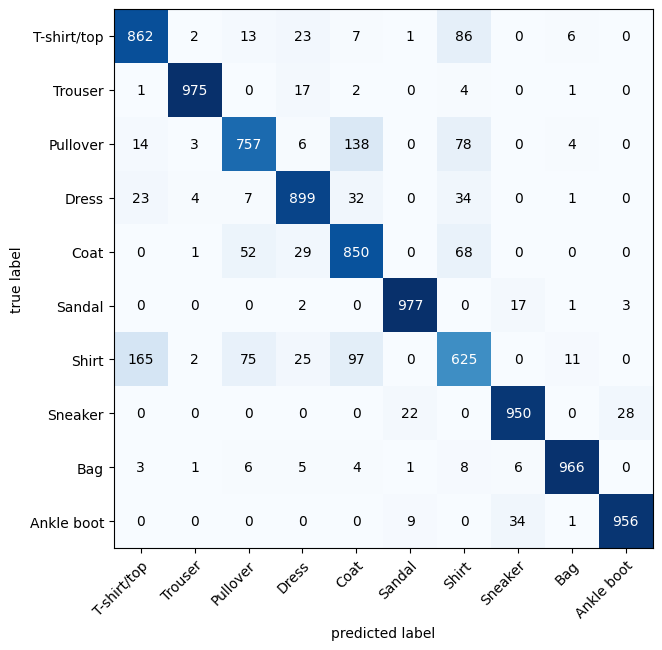

In [72]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

pred = []
truth = []

cnn_model.eval().cpu()
with torch.inference_mode():
    for X, y in test_data:
        pred.append(cnn_model(X.unsqueeze(0)).argmax(1))
        truth.append(y)

confmat = ConfusionMatrix('multiclass', num_classes=10)
cfm = confmat(torch.tensor(pred), torch.tensor(truth))

fig, ax = plot_confusion_matrix(conf_mat=cfm.numpy(), class_names=class_name, figsize=(10, 7))

## 6. Save model

In [73]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'CNN_model_3.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(cnn_model.state_dict(), MODEL_SAVE_PATH)

In [78]:
model = VGG16(1, 10, 10)

model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>